<a href="https://colab.research.google.com/github/nicha1997/Disseration-Project/blob/main/Classification_Analysis_(Predicting_the_Category_of_Risk).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Phase 2: Classification Analysis (Predicting the Category of Risk)**

## **Step 2.0: Library Imports and Data Loading**
The code is performing two fundamental setup tasks:

1. **Importing Libraries:** It loads all the necessary Python libraries for data manipulation (pandas, numpy), visualisation (seaborn, matplotlib), and machine learning (sklearn, imblearn, xgboost, lightgbm, shap).

2. **Loading Data:** It reads two primary Excel files into pandas DataFrames, making them available for the analysis that follows.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap

# Pre-processing and Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Evaluation and Interpretation
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.inspection import PartialDependenceDisplay

# --- Load Initial Data ---
# Make sure files are in the same directory as notebook
try:
    df1_final = pd.read_excel("File1_with_Risk_Category.xlsx")
    df2_final = pd.read_excel("File2_with_Risk_Category.xlsx")
    print("Successfully loaded File1_with_Risk_Category.xlsx and File2_with_Risk_Category.xlsx")
except FileNotFoundError:
    print("ERROR: Make sure Excel files are in the same folder as this notebook.")


Successfully loaded File1_with_Risk_Category.xlsx and File2_with_Risk_Category.xlsx


## **Step 2.1: Final Data Preparation**

*   Defining predictor variables (the financial ratios and ESG score) and your target variable (Risk_Category).
*   Splitting the data into an 80% training set and a 20% testing set.
*   Applying SMOTE to the training set to handle class imbalance.
*   Scaling the features.


In [ ]:
print("================== STEP 1: FINAL DATA PREPARATION ==================\n")

def prepare_data(df, file_name):
    """
    This function encapsulates all data preparation steps in a robust manner,
    ensuring data types and column names are preserved.
    """
    print(f"--- Preparing data for {file_name} ---")

    # a. Define Predictors (X) and Target (y)
    base_predictor_cols = [
        'GM', 'ROA', 'Curr_Ratio', 'Inv_Turnover', 'Inv_Days', 'A/R_Trnovr',
        'A/P_Turnover_Days', 'W/K_Cap_Tur', 'Int_Cov_Ratio', 'ESG_Disc_Score'
    ]
    predictor_cols = base_predictor_cols + ['ESG_Disc_Score_Flag'] if 'ESG_Disc_Score_Flag' in df.columns else base_predictor_cols
    X = df[predictor_cols].copy()
    y = df['Risk_Category']

    if X.isnull().sum().any():
        median_esg_score = X['ESG_Disc_Score'].median()
        X['ESG_Disc_Score'].fillna(median_esg_score, inplace=True)

    # b. Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    # c. Apply SMOTE to Training Data
    print("Applying SMOTE to the training data...")
    smote = SMOTE(random_state=42)
    X_train_smote_np, y_train_smote = smote.fit_resample(X_train, y_train)
    # --- ROBUSTNESS FIX: Convert SMOTE output back to DataFrame ---
    # This preserves the column names for later steps.
    X_train_smote = pd.DataFrame(X_train_smote_np, columns=X_train.columns)

    # d. Scale Features
    print("Scaling features...")
    scaler = StandardScaler()
    X_train_smote_scaled_np = scaler.fit_transform(X_train_smote)
    X_test_scaled_np = scaler.transform(X_test)
    # --- ROBUSTNESS FIX: Convert scaled arrays back to DataFrames ---
    # This ensures consistency and prevents errors in plotting functions.
    X_train_smote_scaled = pd.DataFrame(X_train_smote_scaled_np, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled_np, columns=X_test.columns)

    print(f"Data preparation for {file_name} complete.\n")

    return X_train_smote, X_test, y_train_smote, y_test, X_train_smote_scaled, X_test_scaled, scaler

# Prepare data for both files
X1_train_smote, X1_test, y1_train_smote, y1_test, X1_train_smote_scaled, X1_test_scaled, scaler1 = prepare_data(df1_final, "File 1")
X2_train_smote, X2_test, y2_train_smote, y2_test, X2_train_smote_scaled, X2_test_scaled, scaler2 = prepare_data(df2_final, "File 2")


================== STEP 1: FINAL DATA PREPARATION ==================

--- Preparing data for File 1 ---
Applying SMOTE to the training data...
Scaling features...
Data preparation for File 1 complete.

--- Preparing data for File 2 ---
Applying SMOTE to the training data...
Scaling features...
Data preparation for File 2 complete.



/tmp/ipython-input-3240483706.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['ESG_Disc_Score'].fillna(median_esg_score, inplace=True)


## **Step 2.2: K-Fold Cross-Validation (Model Stability)**

--- 1. K-Fold Cross-Validation (Model Stability) ---

Imputing missing values in full datasets for K-Fold analysis...
No missing numeric values found in File 1.
Imputed missing values in 'ESG_Disc_Score' for File 2.
Imputed missing values in 'Env_Disc_Sc' for File 2.
Imputed missing values in 'Soc_Disc_Sc' for File 2.
Imputed missing values in 'Gov_Disc_Sc' for File 2.
Imputation complete.

Running MANUAL K-Fold analysis for File 1...

  Testing model: Logistic Regression
      Fold 1 F1-Score: 0.8703
      Fold 2 F1-Score: 0.8604


/tmp/ipython-input-1299915611.py:96: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)


      Fold 3 F1-Score: 0.8509
      Fold 4 F1-Score: 0.8218
      Fold 5 F1-Score: 0.8641
      Fold 6 F1-Score: 0.8751
      Fold 7 F1-Score: 0.8770
      Fold 8 F1-Score: 0.8471
      Fold 9 F1-Score: 0.8918
      Fold 10 F1-Score: 0.8850
  --> Logistic Regression: Mean F1-Score: 0.8643 (Std: 0.0195)

  Testing model: Random Forest
      Fold 1 F1-Score: 0.9014
      Fold 2 F1-Score: 0.9402
      Fold 3 F1-Score: 0.9421
      Fold 4 F1-Score: 0.9224
      Fold 5 F1-Score: 0.9404
      Fold 6 F1-Score: 0.9371
      Fold 7 F1-Score: 0.9273
      Fold 8 F1-Score: 0.9197
      Fold 9 F1-Score: 0.9501
      Fold 10 F1-Score: 0.9217
  --> Random Forest: Mean F1-Score: 0.9302 (Std: 0.0137)

  Testing model: XGBoost


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:44:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:44:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


      Fold 1 F1-Score: 0.9632
      Fold 2 F1-Score: 0.9817


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:44:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:44:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


      Fold 3 F1-Score: 0.9790
      Fold 4 F1-Score: 0.9610


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:44:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:44:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


      Fold 5 F1-Score: 0.9766
      Fold 6 F1-Score: 0.9688


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:44:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:44:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


      Fold 7 F1-Score: 0.9713
      Fold 8 F1-Score: 0.9739


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:44:13] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


      Fold 9 F1-Score: 0.9688
      Fold 10 F1-Score: 0.9766
  --> XGBoost: Mean F1-Score: 0.9721 (Std: 0.0064)

  Testing model: LightGBM


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:44:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 2553, number of negative: 2553
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 5106, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
      Fold 1 F1-Score: 0.9630
[LightGBM] [Info] Number of positive: 2553, number of negative: 2553
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 5106, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Fold 2 F1-Score: 0.9870
[LightGBM] [Info] Number of positive: 2553, number of negative: 2553
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5605
[LightGBM] [Info] Number of data points in the train set: 5106, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
      Fold 3 F1-Score: 0.9764
[LightGBM] [Info] Number of positive: 2553, number of negative: 2553


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5608
[LightGBM] [Info] Number of data points in the train set: 5106, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
      Fold 4 F1-Score: 0.9530
[LightGBM] [Info] Number of positive: 2553, number of negative: 2553
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000509 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 5106, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Fold 5 F1-Score: 0.9819
[LightGBM] [Info] Number of positive: 2553, number of negative: 2553
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 5106, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
      Fold 6 F1-Score: 0.9845
[LightGBM] [Info] Number of positive: 2553, number of negative: 2553
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5607
[LightGBM] [Info] Number of data points in the train set: 5106, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
      Fold 7 F1-Score: 0.9791
[LightGBM] [Info] Number of positive: 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Fold 8 F1-Score: 0.9765
[LightGBM] [Info] Number of positive: 2554, number of negative: 2554
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5605
[LightGBM] [Info] Number of data points in the train set: 5108, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
      Fold 9 F1-Score: 0.9713
[LightGBM] [Info] Number of positive: 2554, number of negative: 2554
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5606
[LightGBM] [Info] Number of data points in the train set: 5108, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/tmp/ipython-input-1299915611.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='F1-Score', data=plot_df, palette='Set2')


      Fold 10 F1-Score: 0.9792
  --> LightGBM: Mean F1-Score: 0.9752 (Std: 0.0098)


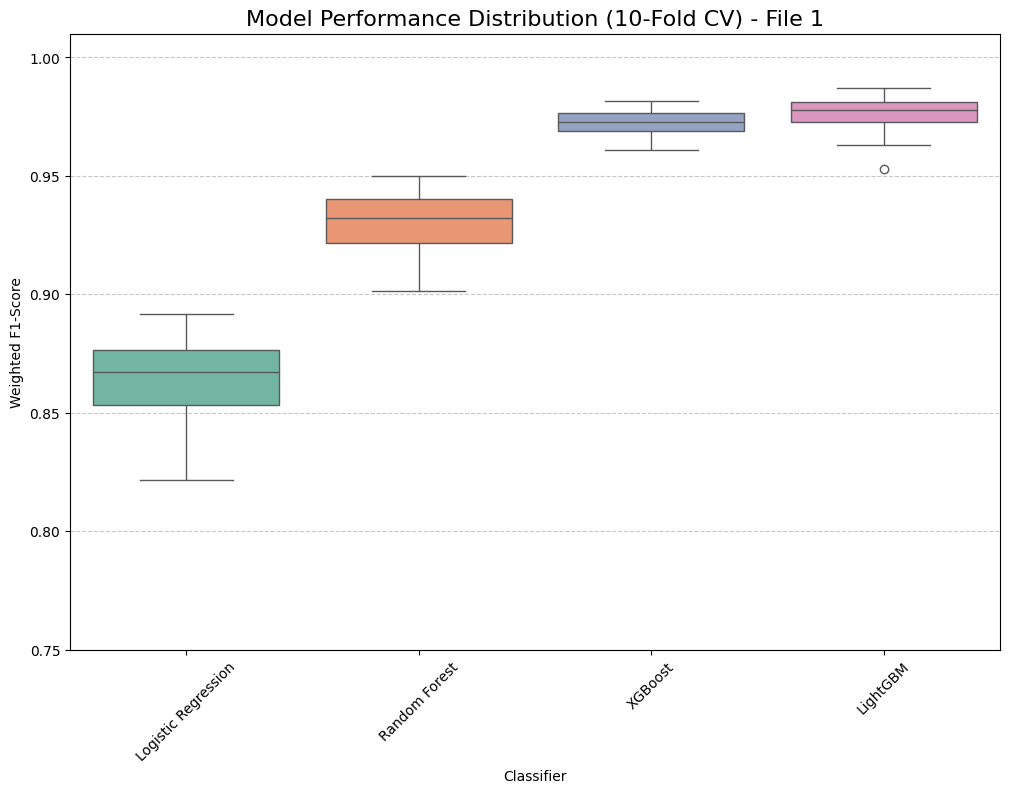


Running MANUAL K-Fold analysis for File 2...

  Testing model: Logistic Regression
      Fold 1 F1-Score: 0.8490
      Fold 2 F1-Score: 0.8257
      Fold 3 F1-Score: 0.8507
      Fold 4 F1-Score: 0.8046
      Fold 5 F1-Score: 0.8346
      Fold 6 F1-Score: 0.8438
      Fold 7 F1-Score: 0.8234
      Fold 8 F1-Score: 0.8648
      Fold 9 F1-Score: 0.8444
      Fold 10 F1-Score: 0.8473
  --> Logistic Regression: Mean F1-Score: 0.8388 (Std: 0.0163)

  Testing model: Random Forest
      Fold 1 F1-Score: 0.9366
      Fold 2 F1-Score: 0.9402
      Fold 3 F1-Score: 0.9216
      Fold 4 F1-Score: 0.9402
      Fold 5 F1-Score: 0.9460
      Fold 6 F1-Score: 0.9463
      Fold 7 F1-Score: 0.9365
      Fold 8 F1-Score: 0.9308
      Fold 9 F1-Score: 0.9586
      Fold 10 F1-Score: 0.9500
  --> Random Forest: Mean F1-Score: 0.9407 (Std: 0.0098)

  Testing model: XGBoost


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:45:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


      Fold 1 F1-Score: 0.9805


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:45:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


      Fold 2 F1-Score: 0.9805


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:45:03] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


      Fold 3 F1-Score: 0.9793


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:45:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


      Fold 4 F1-Score: 0.9830


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:45:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


      Fold 5 F1-Score: 0.9842


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:45:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


      Fold 6 F1-Score: 0.9866


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:45:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


      Fold 7 F1-Score: 0.9878


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:45:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


      Fold 8 F1-Score: 0.9854


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:45:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


      Fold 9 F1-Score: 0.9818


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:45:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


      Fold 10 F1-Score: 0.9817
  --> XGBoost: Mean F1-Score: 0.9831 (Std: 0.0027)

  Testing model: LightGBM
[LightGBM] [Info] Number of positive: 4699, number of negative: 4699
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5573
[LightGBM] [Info] Number of data points in the train set: 9398, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Fold 1 F1-Score: 0.9817
[LightGBM] [Info] Number of positive: 4699, number of negative: 4699
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5567
[LightGBM] [Info] Number of data points in the train set: 9398, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Fold 2 F1-Score: 0.9817
[LightGBM] [Info] Number of positive: 4700, number of negative: 4700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5573
[LightGBM] [Info] Number of data points in the train set: 9400, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Fold 3 F1-Score: 0.9854
[LightGBM] [Info] Number of positive: 4700, number of negative: 4700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5575
[LightGBM] [Info] Number of data points in the train set: 9400, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Fold 4 F1-Score: 0.9817
[LightGBM] [Info] Number of positive: 4700, number of negative: 4700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5577
[LightGBM] [Info] Number of data points in the train set: 9400, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Fold 5 F1-Score: 0.9805
[LightGBM] [Info] Number of positive: 4700, number of negative: 4700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001128 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5571
[LightGBM] [Info] Number of data points in the train set: 9400, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Fold 6 F1-Score: 0.9866
[LightGBM] [Info] Number of positive: 4700, number of negative: 4700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5568
[LightGBM] [Info] Number of data points in the train set: 9400, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Fold 7 F1-Score: 0.9817
[LightGBM] [Info] Number of positive: 4700, number of negative: 4700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5566
[LightGBM] [Info] Number of data points in the train set: 9400, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Fold 8 F1-Score: 0.9805
[LightGBM] [Info] Number of positive: 4700, number of negative: 4700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5577
[LightGBM] [Info] Number of data points in the train set: 9400, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


      Fold 9 F1-Score: 0.9842
[LightGBM] [Info] Number of positive: 4700, number of negative: 4700
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5577
[LightGBM] [Info] Number of data points in the train set: 9400, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
      Fold 10 F1-Score: 0.9903
  --> LightGBM: Mean F1-Score: 0.9834 (Std: 0.0030)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/tmp/ipython-input-1299915611.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='F1-Score', data=plot_df, palette='Set2')


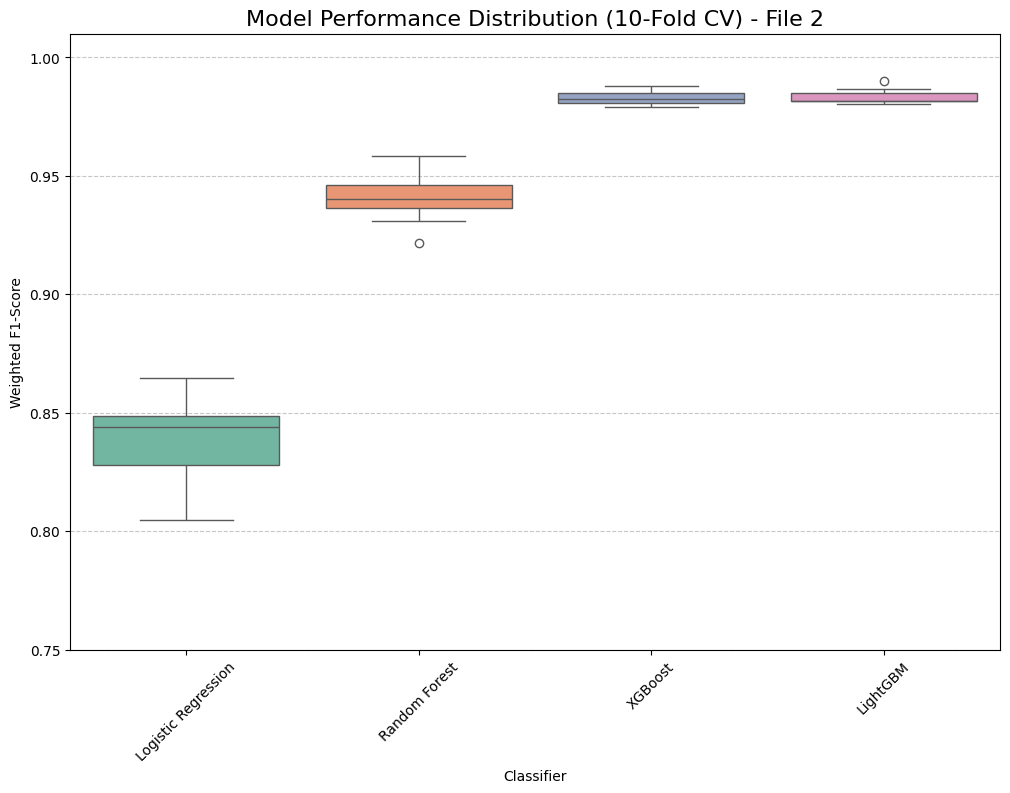


--- ALL ANALYSES COMPLETE. You can now run the results script. ---


In [ ]:
print("--- 1. K-Fold Cross-Validation (Model Stability) ---")

models_kfold = {
    "Logistic Regression": LogisticRegression(random_state=42, solver='liblinear'),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    "LightGBM": LGBMClassifier(random_state=42)
}

# This import is needed for the F1-score calculation inside the loop
from sklearn.metrics import f1_score

def run_kfold_analysis_manual(X, y, file_name):
    print(f"\nRunning MANUAL K-Fold analysis for {file_name}...")

    # This will store the final results for the boxplot
    plot_df_data = {'Model': [], 'F1-Score': []}

    # Loop through each of the 5 models
    for name, model in models_kfold.items():
        print(f"\n  Testing model: {name}")

        # This list will store the 10 scores for the current model
        fold_scores = []

        # Create the 10-fold splitter
        cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

        # --- THIS IS THE MANUAL LOOP ---
        # It will loop 10 times, once for each fold
        for fold_idx, (train_index, test_index) in enumerate(cv.split(X, y)):
            # print(f"    Running Fold {fold_idx + 1}/10...") # Optional: for more verbose output

            # 1. Split the data for this specific fold
            X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
            y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]

            # 2. Apply SMOTE to the training data of this fold
            smote = SMOTE(random_state=42)
            X_train_fold_smote, y_train_fold_smote = smote.fit_resample(X_train_fold, y_train_fold)

            # 3. Scale the features for this fold
            scaler = StandardScaler()
            X_train_fold_scaled = scaler.fit_transform(X_train_fold_smote)
            X_test_fold_scaled = scaler.transform(X_test_fold)

            # 4. Train the model on this fold's processed training data
            model.fit(X_train_fold_scaled, y_train_fold_smote)

            # 5. Make predictions on this fold's processed test data
            predictions = model.predict(X_test_fold_scaled)

            # 6. Calculate and store the F1-score for this fold
            score = f1_score(y_test_fold, predictions, average='weighted')

            # --- NEW: Print the score for the current fold ---
            print(f"      Fold {fold_idx + 1} F1-Score: {score:.4f}")

            fold_scores.append(score)

        # After the 10 folds are complete, calculate the average and std dev
        print(f"  --> {name}: Mean F1-Score: {np.mean(fold_scores):.4f} (Std: {np.std(fold_scores):.4f})")

        # Add the 10 scores to our plot data
        plot_df_data['Model'].extend([name] * 10)
        plot_df_data['F1-Score'].extend(fold_scores)

    # --- Create the final boxplot ---
    plot_df = pd.DataFrame(plot_df_data)

    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Model', y='F1-Score', data=plot_df, palette='Set2')

    plt.title(f'Model Performance Distribution (10-Fold CV) - {file_name}', fontsize=16)
    plt.ylabel('Weighted F1-Score')
    plt.xlabel('Classifier')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0.75, 1.01)
    plt.show()

    return plot_df_data

# --- Impute missing values before running K-Fold analysis ---
print("\nImputing missing values in full datasets for K-Fold analysis...")
df1_kfold = df1_final.copy()
df2_kfold = df2_final.copy()

def impute_numeric_nans(df, df_name):
    numeric_cols_with_nan = df.select_dtypes(include=np.number).isnull().sum()
    numeric_cols_with_nan = numeric_cols_with_nan[numeric_cols_with_nan > 0].index

    if not numeric_cols_with_nan.empty:
        for col in numeric_cols_with_nan:
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)
            print(f"Imputed missing values in '{col}' for {df_name}.")
    else:
        print(f"No missing numeric values found in {df_name}.")

impute_numeric_nans(df1_kfold, "File 1")
impute_numeric_nans(df2_kfold, "File 2")

print("Imputation complete.")

# --- Run for both files using the imputed dataframes ---
X1_kfold = df1_kfold.drop(columns=['Cash_Flow_to_Debt_Ratio', 'Risk_Category', 'Company_Ticker', 'Company_Name', 'Year', 'Country', 'BICS_Industry_Group', 'BICS_Industry', 'BICS_Sub_Industry'], errors='ignore')
y1_kfold = df1_kfold['Risk_Category']
kfold_results1 = run_kfold_analysis_manual(X1_kfold, y1_kfold, "File 1")

X2_kfold = df2_kfold.drop(columns=['Cash_Flow_to_Debt_Ratio', 'Risk_Category', 'Company_Ticker', 'Company_Name', 'Year', 'Country', 'BICS_Industry_Group', 'BICS_Industry', 'BICS_Sub_Industry'], errors='ignore')
y2_kfold = df2_kfold['Risk_Category']
kfold_results2 = run_kfold_analysis_manual(X2_kfold, y2_kfold, "File 2")

print("\n--- ALL ANALYSES COMPLETE. You can now run the results script. ---")


--- Generating Final Summaries ---

--- K-Fold Cross-Validation Summary Table for File 1 ---


,Model,Mean F1-Score,Std. Dev.
0,LightGBM,0.9752,0.010327
1,XGBoost,0.9721,0.006745
2,Random Forest,0.9302,0.014438
3,Logistic Regression,0.8643,0.020552


/tmp/ipython-input-2279745233.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='F1-Score', data=plot_df, palette='Set2')


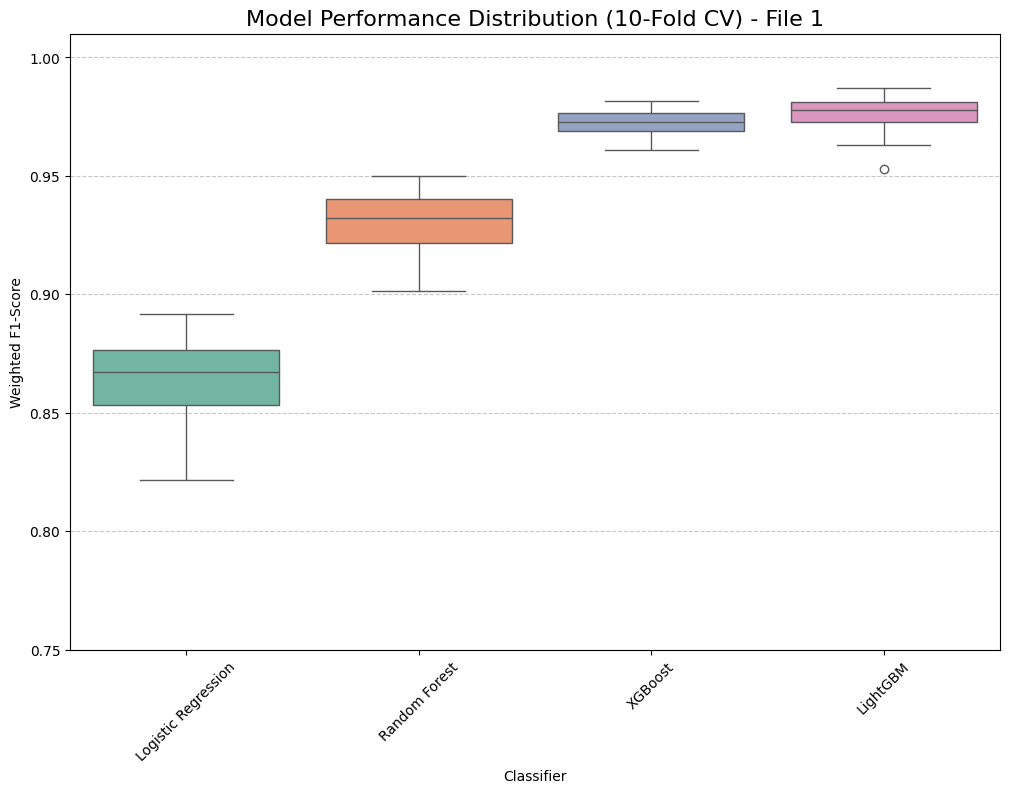


--- K-Fold Cross-Validation Summary Table for File 2 ---


,Model,Mean F1-Score,Std. Dev.
0,LightGBM,0.9834,0.003151
1,XGBoost,0.9831,0.002845
2,Random Forest,0.9407,0.010350
3,Logistic Regression,0.8388,0.017145


/tmp/ipython-input-2279745233.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Model', y='F1-Score', data=plot_df, palette='Set2')


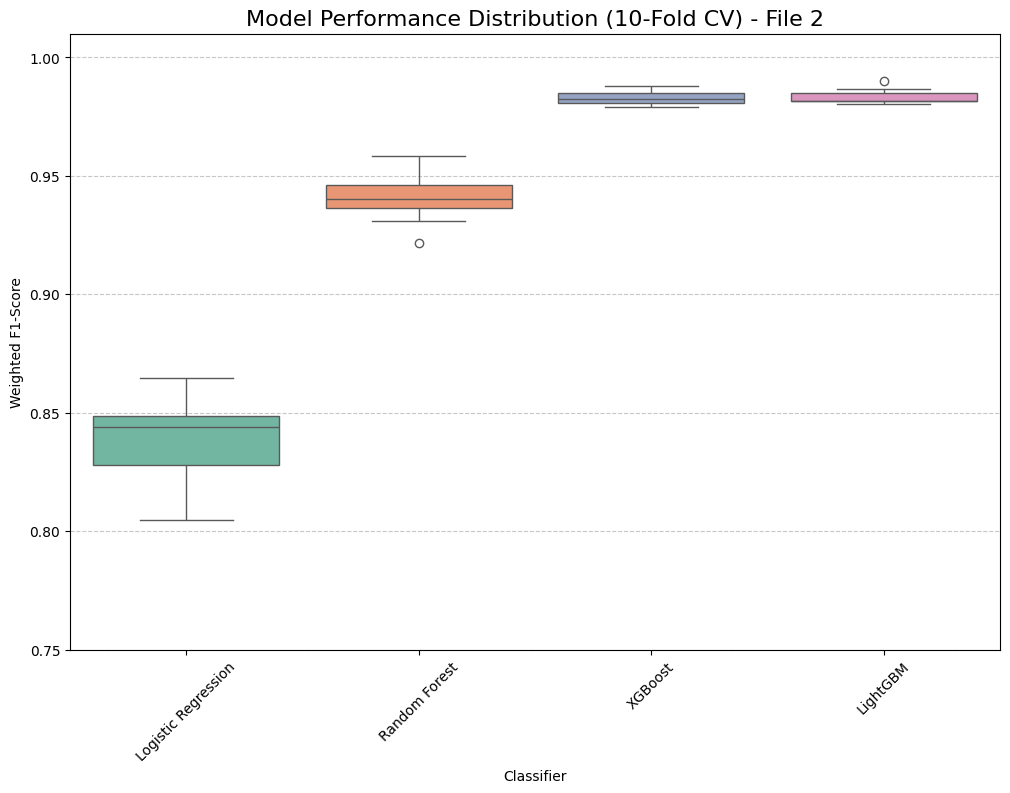

In [ ]:
def create_summary_visuals(plot_df_data, file_name):
    """
    This function takes the results dictionary from the K-Fold loop and creates
    a final summary table and box plot.
    """

    # 1. Convert the results dictionary to a DataFrame for easier processing
    plot_df = pd.DataFrame(plot_df_data)

    # 2. Create the Summary Table by calculating the mean and standard deviation
    summary_table = plot_df.groupby('Model')['F1-Score'].agg(['mean', 'std']).reset_index()
    summary_table = summary_table.rename(columns={'mean': 'Mean F1-Score', 'std': 'Std. Dev.'})

    # Sort the table by Mean F1-Score in descending order
    summary_table = summary_table.sort_values(by='Mean F1-Score', ascending=False).reset_index(drop=True)

    print(f"\n--- K-Fold Cross-Validation Summary Table for {file_name} ---")
    # display(summary_table.style.format({'Mean F1-Score': '{:.4f}', 'Std. Dev.': '{:.4f}'}))

    # Style the DataFrame for better presentation
    styled_df = summary_table.style.format({
        'Mean F1-Score': '{:.4f}',
        'Std Deviation': '{:.4f}'
    }).set_caption(f"<b>Model Performance Summary ({file_name})</b>") \
      .set_table_styles([{
          'selector': 'caption',
          'props': [('color', 'black'), ('font-size', '16px')]
      }]) \
      .bar(subset=['Mean F1-Score'], color='#5fba7d', vmin=0.8) \
      .background_gradient(subset=['Std. Dev.'], cmap='Reds')

    display(styled_df)

    # 3. Create the Final Box Plot to visualize the distribution of scores
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Model', y='F1-Score', data=plot_df, palette='Set2')

    plt.title(f'Model Performance Distribution (10-Fold CV) - {file_name}', fontsize=16)
    plt.ylabel('Weighted F1-Score')
    plt.xlabel('Classifier')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0.75, 1.01) # Zoom in on the y-axis for better visibility
    plt.show()

# --- Run the summary function for both files ---
# This code assumes that 'kfold_results1' and 'kfold_results2' were created
# by running the manual K-Fold analysis in the previous step.
try:
    print("\n--- Generating Final Summaries ---")
    create_summary_visuals(kfold_results1, "File 1")
    create_summary_visuals(kfold_results2, "File 2")
except NameError:
    print("ERROR: Please make sure you have run the 'Step 2A: K-Fold Cross-Validation (Capture Results)'")
    print("code block first to generate the 'kfold_results1' and 'kfold_results2' variables.")

## **Step 2.3: Model Training and Evaluation**

*   Hyperparameter Tuning: It finds the best settings for each model using GridSearchCV.
*   Final Evaluation: It tests the performance of the optimised models.
* Visualisation: It creates confusion matrices and feature importance plots to visualise the results.

### **Step 2.3A: Hyperparameter Tuning**

In [ ]:
print("\n--- Step 2.3A: Hyperparameter Tuning (Finding the Best Model Settings) ---")

def find_best_hyperparameters(X_train_smote, y_train_smote, X_train_smote_scaled, file_name):
    """
    This function uses GridSearchCV to find the best hyperparameters for each model.
    """
    print(f"\nRunning Hyperparameter Tuning for {file_name}...")

    # Define the models and the grid of parameters to search for each
    param_grids = {
        "Logistic Regression": {'C': [0.1, 1, 10], 'solver': ['liblinear']},
        "Random Forest": {'n_estimators': [100, 200], 'max_depth': [10, 20]},
        "XGBoost": {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]},
        "LightGBM": {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'num_leaves': [20, 31]}
    }

    models = {
        "Logistic Regression": LogisticRegression(random_state=42),
        "Random Forest": RandomForestClassifier(random_state=42),
        "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        "LightGBM": LGBMClassifier(random_state=42)
    }

    best_params_dict = {}

    for name, model in models.items():
        print(f"  Tuning {name}...")

        # Use scaled data for Logistic Regression, original data for tree-based models
        X_train_data = X_train_smote_scaled if name == "Logistic Regression" else X_train_smote

        # GridSearchCV performs a cross-validated search over the parameter grid
        grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
        grid_search.fit(X_train_data, y_train_smote)

        # Store the best parameters found
        best_params_dict[name] = grid_search.best_params_
        print(f"  --> Best parameters for {name}: {grid_search.best_params_}")

    return best_params_dict

# Run the tuning process for both files and store the results
best_params1 = find_best_hyperparameters(X1_train_smote, y1_train_smote, X1_train_smote_scaled, "File 1")
best_params2 = find_best_hyperparameters(X2_train_smote, y2_train_smote, X2_train_smote_scaled, "File 2")

print("\nHyperparameter tuning complete. The best parameters for each model have been found.")



--- Step 2.3A: Hyperparameter Tuning (Finding the Best Model Settings) ---

Running Hyperparameter Tuning for File 1...
  Tuning Logistic Regression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
  --> Best parameters for Logistic Regression: {'C': 10, 'solver': 'liblinear'}
  Tuning Random Forest...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
  --> Best parameters for Random Forest: {'max_depth': 20, 'n_estimators': 200}
  Tuning XGBoost...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:48:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  --> Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
  Tuning LightGBM...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Number of positive: 2269, number of negative: 2269
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 4538, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
  --> Best parameters for LightGBM: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 31}

Running Hyperparameter Tuning for File 2...
  Tuning Logistic Regression...
Fitting 3 folds for each of 3 candidates, totalling 9 fits
  --> Best parameters for Logistic Regression: {'C': 10, 'solver': 'liblinear'}
  Tuning Random Forest...
Fitting 3 folds for each of 4 candidates, totall

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:51:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  --> Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}
  Tuning LightGBM...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[LightGBM] [Info] Number of positive: 4177, number of negative: 4177
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000583 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2552
[LightGBM] [Info] Number of data points in the train set: 8354, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
  --> Best parameters for LightGBM: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 31}

Hyperparameter tuning complete. The best parameters for each model have been found.


### **Step 2.3B: Final Model Training and Evaluation**


--- Step 3B: Final Model Training and Evaluation (Using Best Hyperparameters) ---

Training final, optimized models for File 1...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:56:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 2269, number of negative: 2269
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 4538, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


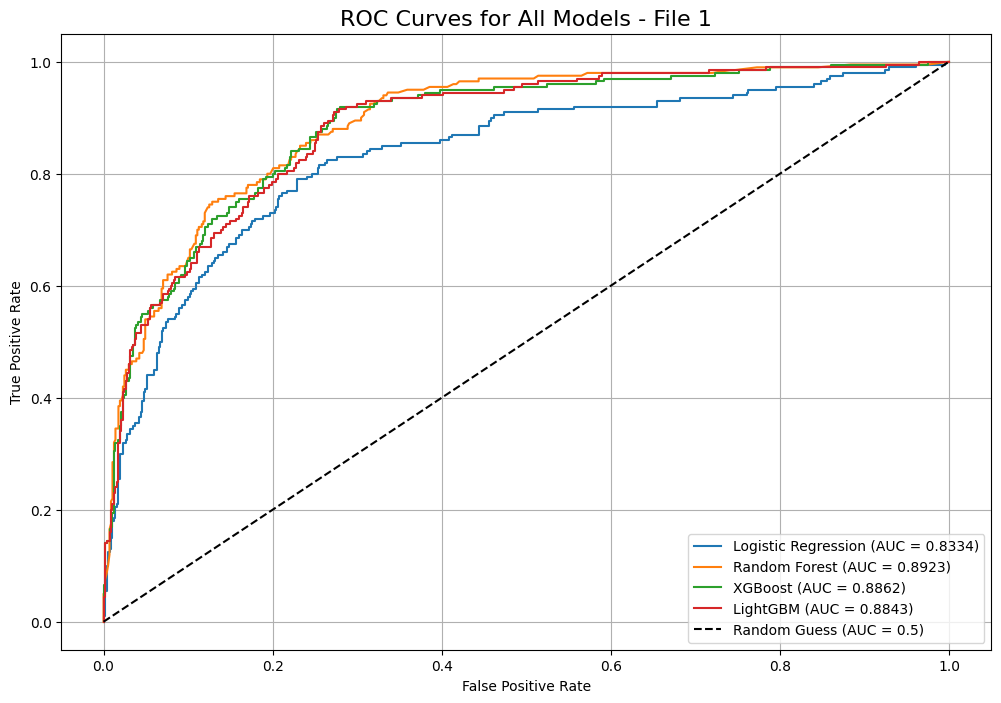


--- Overall Model Performance Summary for File 1 ---


,Model,Accuracy,AUC,Precision,Recall,F1-Score,Support
0,Logistic Regression,0.7721,0.8334,0.8111,0.7721,0.7827,768.000000
1,Random Forest,0.8242,0.8923,0.8381,0.8242,0.8289,768.000000
2,XGBoost,0.8086,0.8862,0.8277,0.8086,0.8147,768.000000
3,LightGBM,0.8112,0.8843,0.8223,0.8112,0.8153,768.000000



--- Evaluation Plots for Logistic Regression (File 1) ---


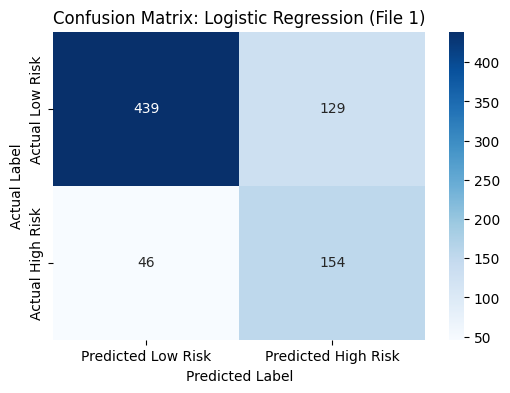

/tmp/ipython-input-3158669946.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coefficient', y='feature', data=coeff_df, palette=coeff_df['color'].tolist())


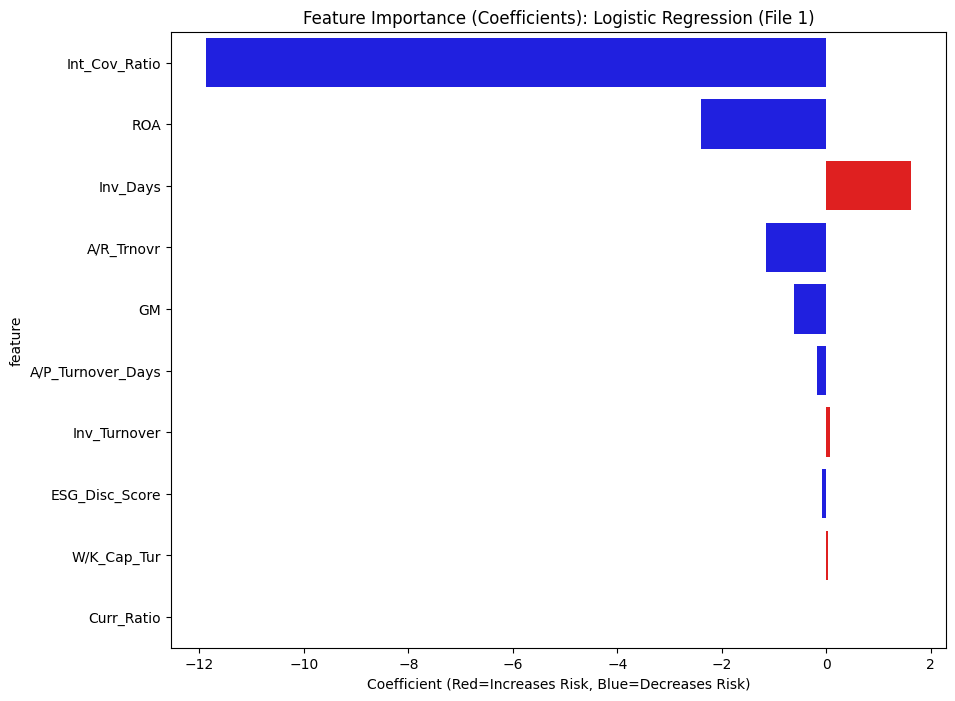


--- Evaluation Plots for Random Forest (File 1) ---


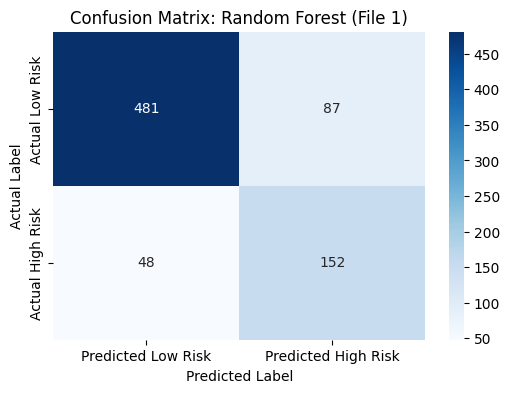

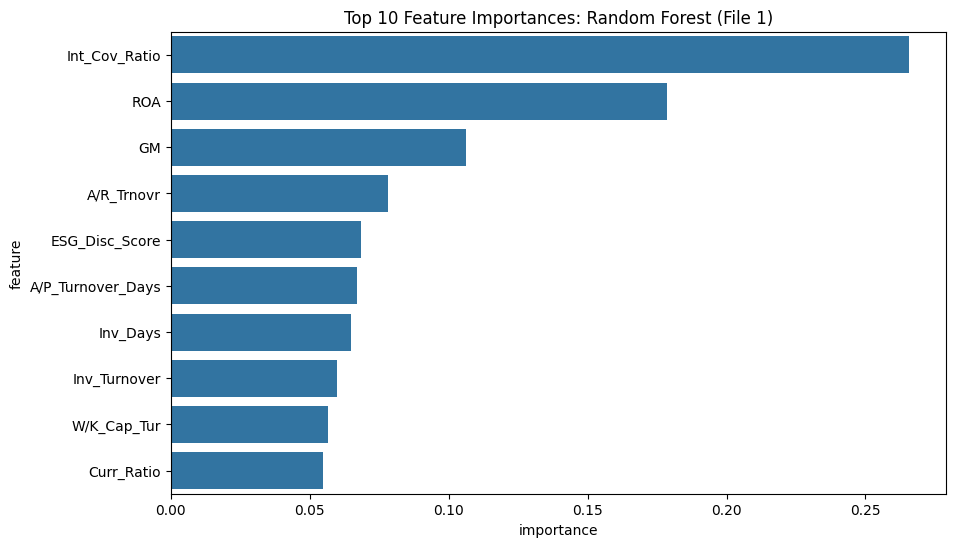


--- Evaluation Plots for XGBoost (File 1) ---


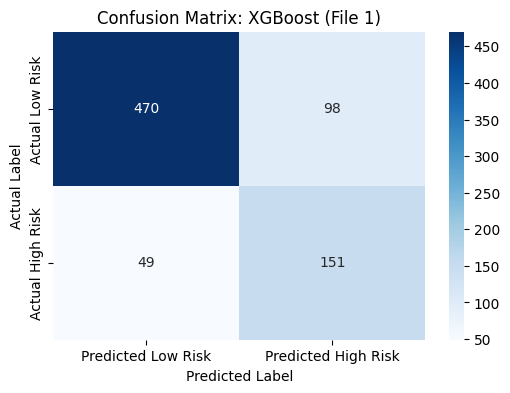

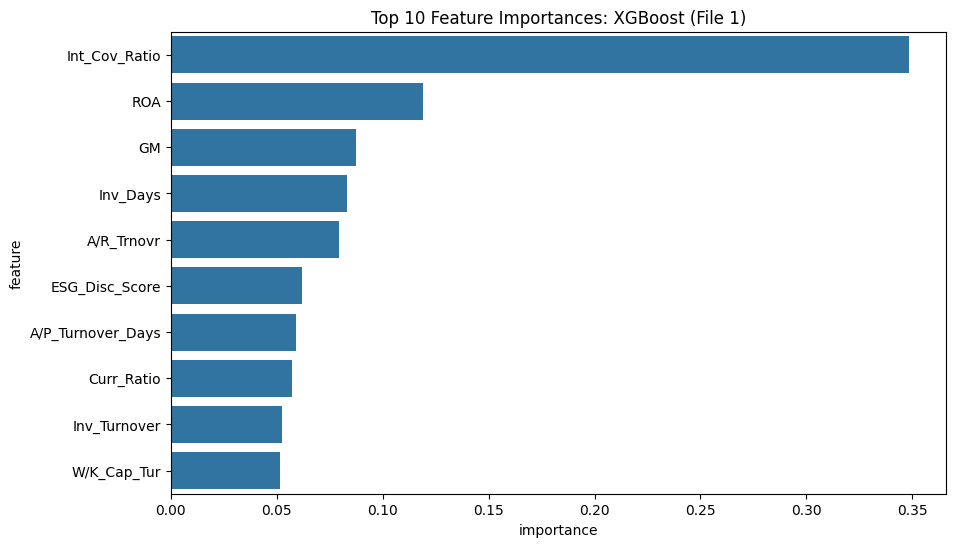


--- Evaluation Plots for LightGBM (File 1) ---


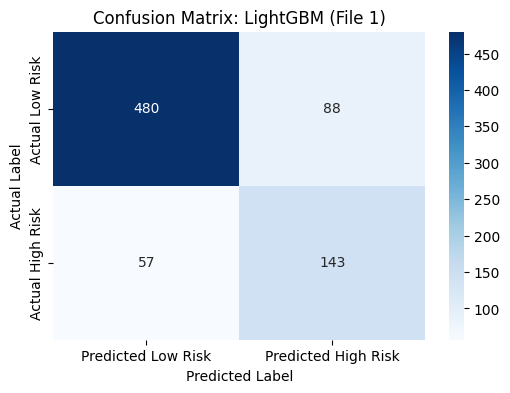

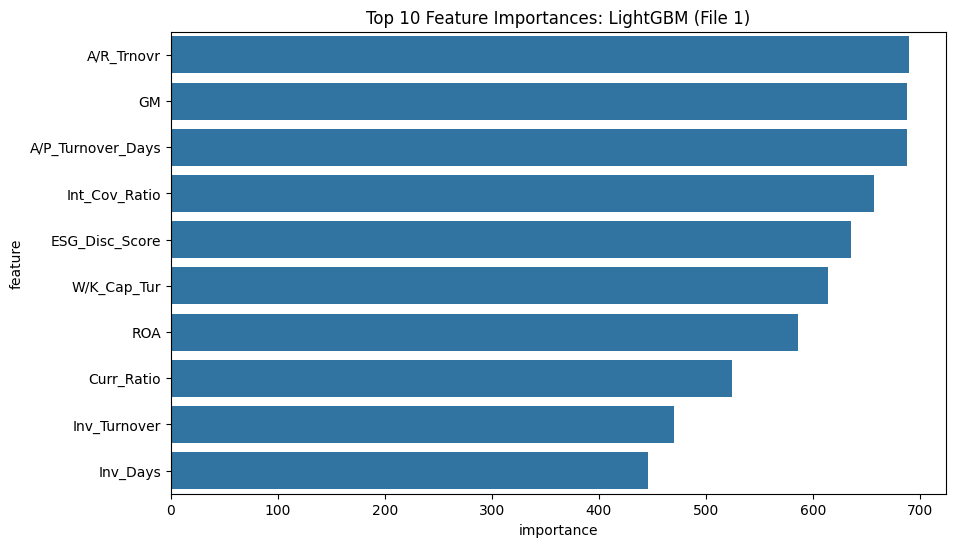


Training final, optimized models for File 2...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:56:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 4177, number of negative: 4177
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2553
[LightGBM] [Info] Number of data points in the train set: 8354, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


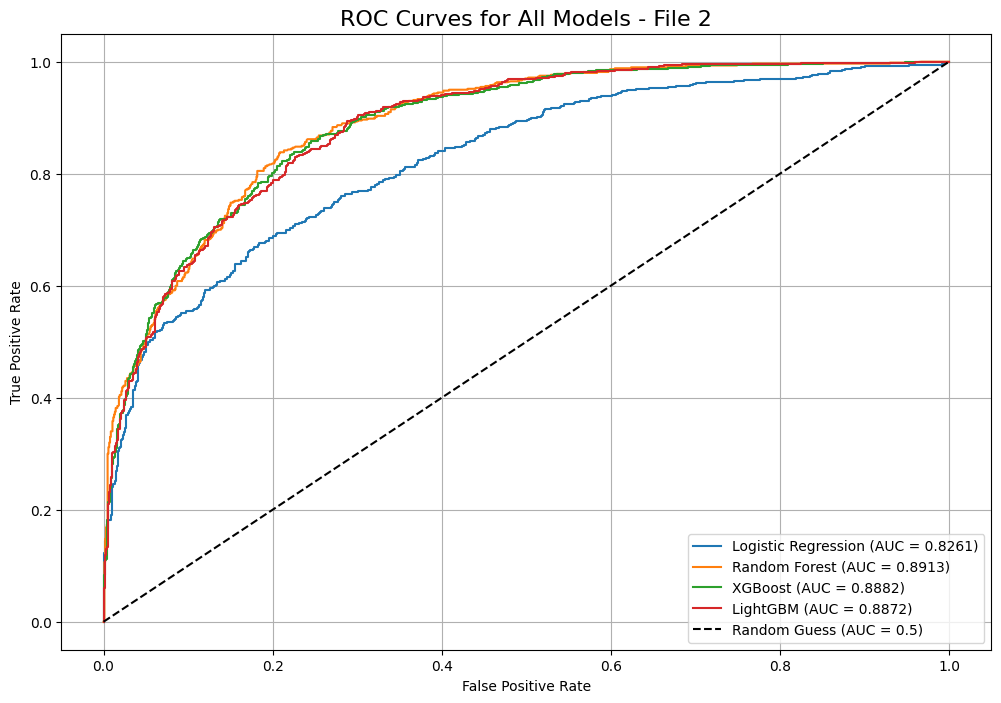


--- Overall Model Performance Summary for File 2 ---


,Model,Accuracy,AUC,Precision,Recall,F1-Score,Support
0,Logistic Regression,0.7495,0.8261,0.7556,0.7495,0.7517,1645.000000
1,Random Forest,0.8097,0.8913,0.8128,0.8097,0.8109,1645.000000
2,XGBoost,0.8036,0.8882,0.8062,0.8036,0.8046,1645.000000
3,LightGBM,0.8036,0.8872,0.8043,0.8036,0.8040,1645.000000



--- Evaluation Plots for Logistic Regression (File 2) ---


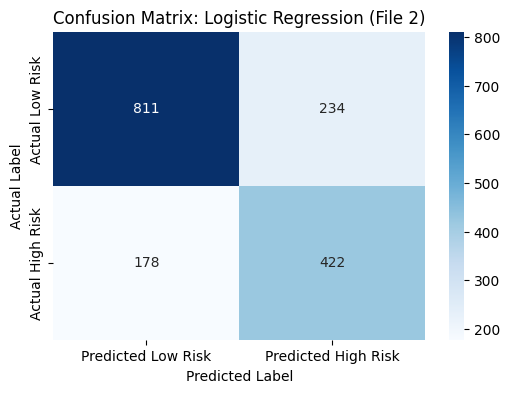

/tmp/ipython-input-3158669946.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='coefficient', y='feature', data=coeff_df, palette=coeff_df['color'].tolist())


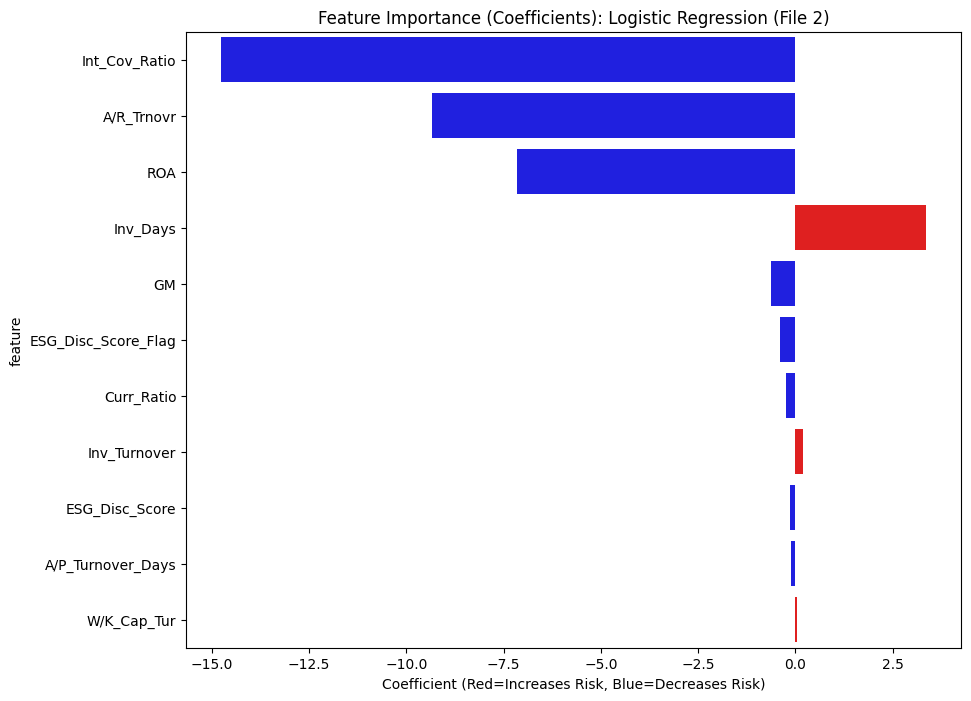


--- Evaluation Plots for Random Forest (File 2) ---


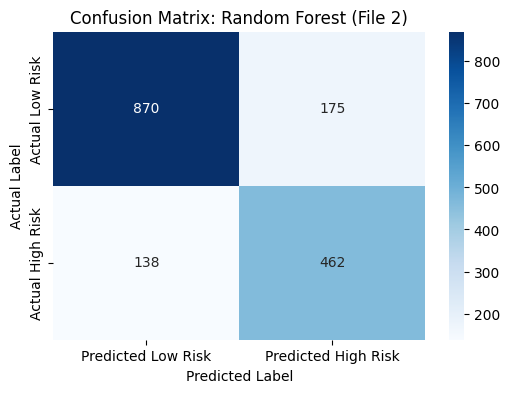

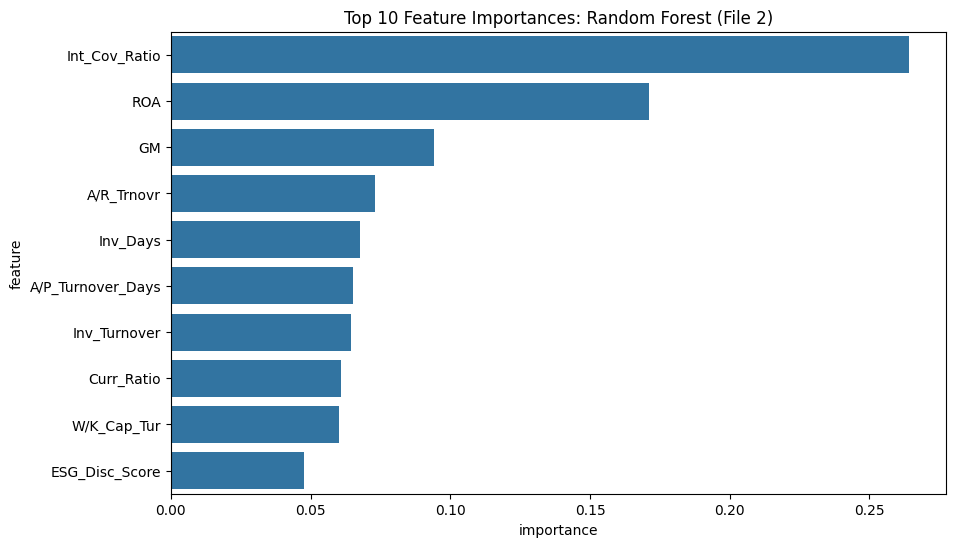


--- Evaluation Plots for XGBoost (File 2) ---


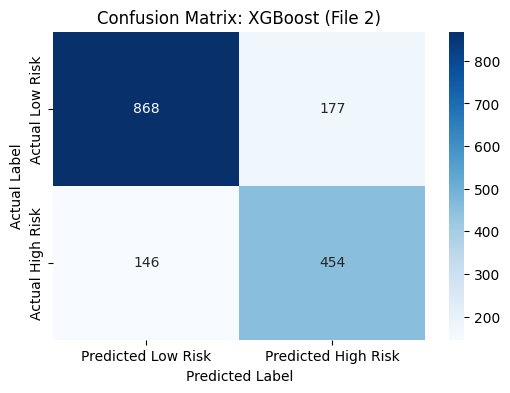

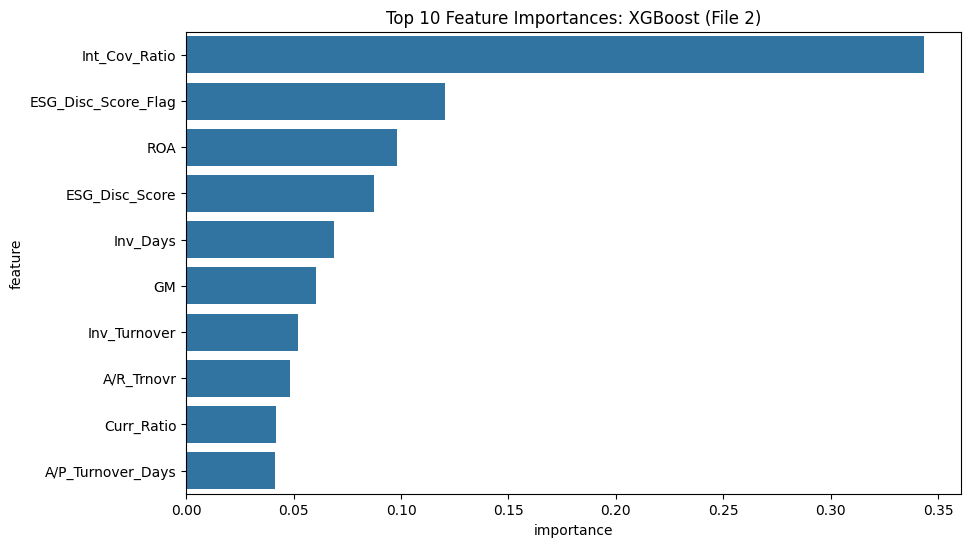


--- Evaluation Plots for LightGBM (File 2) ---


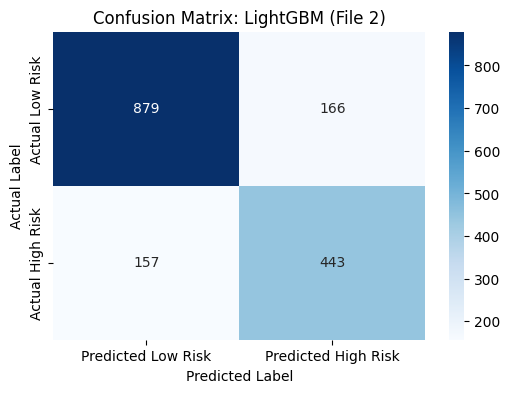

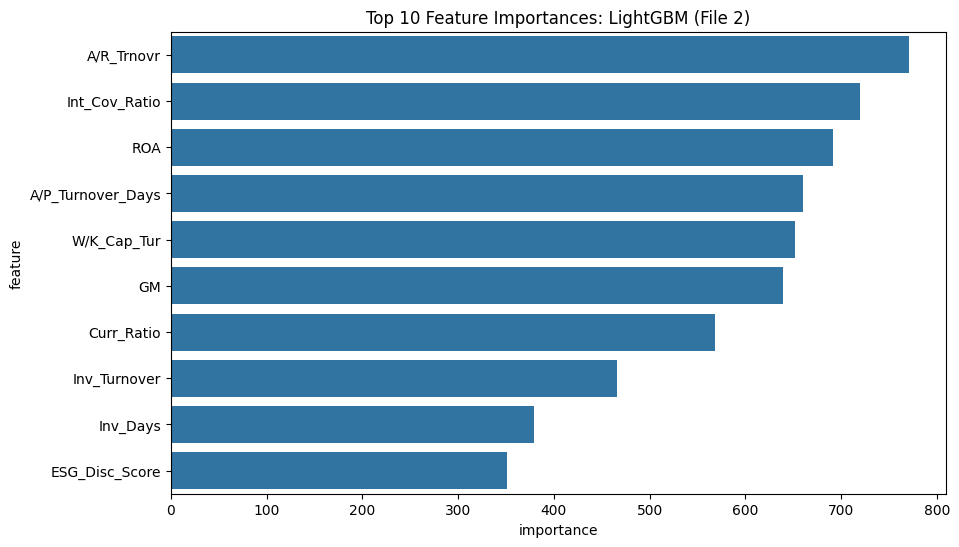

In [ ]:
print("\n--- Step 3B: Final Model Training and Evaluation (Using Best Hyperparameters) ---")

def final_evaluation(X_train_smote_scaled, y_train_smote, X_test_scaled, y_test, X_test, best_params, file_name):
    """
    This function trains the final models using the best hyperparameters and
    generates all evaluation plots and summary tables.
    """
    final_models = {}
    roc_data = {}
    evaluation_results = []

    # Define the models, now using the best parameters found in the previous step
    models_to_train = {
        "Logistic Regression": LogisticRegression(random_state=42, **best_params["Logistic Regression"]),
        "Random Forest": RandomForestClassifier(random_state=42, **best_params["Random Forest"]),
        "XGBoost": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss', **best_params["XGBoost"]),
        "LightGBM": LGBMClassifier(random_state=42, **best_params["LightGBM"])
    }

    print(f"\nTraining final, optimized models for {file_name}...")
    for name, model in models_to_train.items():
        # Use scaled training data for all models for consistency in this final step
        model.fit(X_train_smote_scaled, y_train_smote)
        final_models[name] = model

        predictions = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        roc_data[name] = {'fpr': fpr, 'tpr': tpr, 'auc': roc_auc}

        report_dict = classification_report(y_test, predictions, output_dict=True)
        res = {'Model': name, 'AUC': roc_auc, 'Accuracy': report_dict['accuracy']}
        res.update(report_dict['weighted avg'])
        evaluation_results.append(res)

    # --- Generate Visualizations ---

    # 1. Plot Combined ROC Curves
    plt.figure(figsize=(12, 8))
    for name, data in roc_data.items():
        plt.plot(data['fpr'], data['tpr'], label=f"{name} (AUC = {data['auc']:.4f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curves for All Models - {file_name}', fontsize=16)
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # 2. Display Final Summary Table
    results_df = pd.DataFrame(evaluation_results)
    results_df = results_df.rename(columns={'f1-score': 'F1-Score', 'precision': 'Precision', 'recall': 'Recall', 'support': 'Support'})
    results_df = results_df[['Model', 'Accuracy', 'AUC', 'Precision', 'Recall', 'F1-Score', 'Support']]
    print(f"\n--- Overall Model Performance Summary for {file_name} ---")
    display(results_df.style.format({'Accuracy': '{:.4f}', 'AUC': '{:.4f}', 'Precision': '{:.4f}', 'Recall': '{:.4f}', 'F1-Score': '{:.4f}'}))

    # 3. Generate Confusion Matrix and Feature Importance plots
    for name, model in final_models.items():
        print(f"\n--- Evaluation Plots for {name} ({file_name}) ---")

        cm = confusion_matrix(y_test, model.predict(X_test_scaled))
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted Low Risk', 'Predicted High Risk'], yticklabels=['Actual Low Risk', 'Actual High Risk'])
        plt.title(f'Confusion Matrix: {name} ({file_name})')
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')
        plt.show()

        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            feature_names = X_test.columns
            feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False).head(10)
            plt.figure(figsize=(10, 6))
            sns.barplot(x='importance', y='feature', data=feature_importance_df)
            plt.title(f'Top 10 Feature Importances: {name} ({file_name})')
            plt.show()
        elif name == "Logistic Regression":
            coeffs = model.coef_[0]
            feature_names = X_test.columns
            coeff_df = pd.DataFrame({'feature': feature_names, 'coefficient': coeffs})
            coeff_df['abs_coefficient'] = np.abs(coeff_df['coefficient'])
            coeff_df = coeff_df.sort_values('abs_coefficient', ascending=False)
            coeff_df['color'] = ['red' if c > 0 else 'blue' for c in coeff_df['coefficient']]
            plt.figure(figsize=(10, 8))
            sns.barplot(x='coefficient', y='feature', data=coeff_df, palette=coeff_df['color'].tolist())
            plt.title(f'Feature Importance (Coefficients): {name} ({file_name})')
            plt.xlabel('Coefficient (Red=Increases Risk, Blue=Decreases Risk)')
            plt.show()

    return final_models

# Run for both files using the data prepared in Step 1 and the parameters found in Step 3A
final_models1 = final_evaluation(X1_train_smote_scaled, y1_train_smote, X1_test_scaled, y1_test, X1_test, best_params1, "File 1")
final_models2 = final_evaluation(X2_train_smote_scaled, y2_train_smote, X2_test_scaled, y2_test, X2_test, best_params2, "File 2")


## **Step 2.4: Model Explanation with SHAP**

*   Selects best-performing model (Random Forest).
*   Creates a SHAP explainer.
*   Calculates the SHAP values.
*   Visualises the results with a SHAP summary plot.


--- 4. SHAP Analysis (Explaining Model Predictions) ---
Generating SHAP plot for File 1...


100%|===================| 1535/1536 [01:22<00:00]       

Displaying SHAP Summary Plot (Beeswarm)...


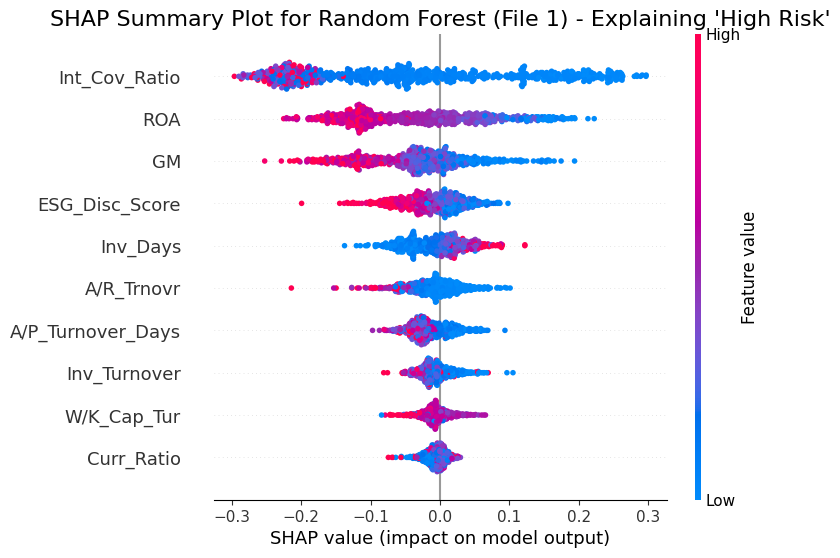

Generating SHAP plot for File 2...


100%|===================| 3280/3290 [04:21<00:00]       

Displaying SHAP Summary Plot (Beeswarm)...


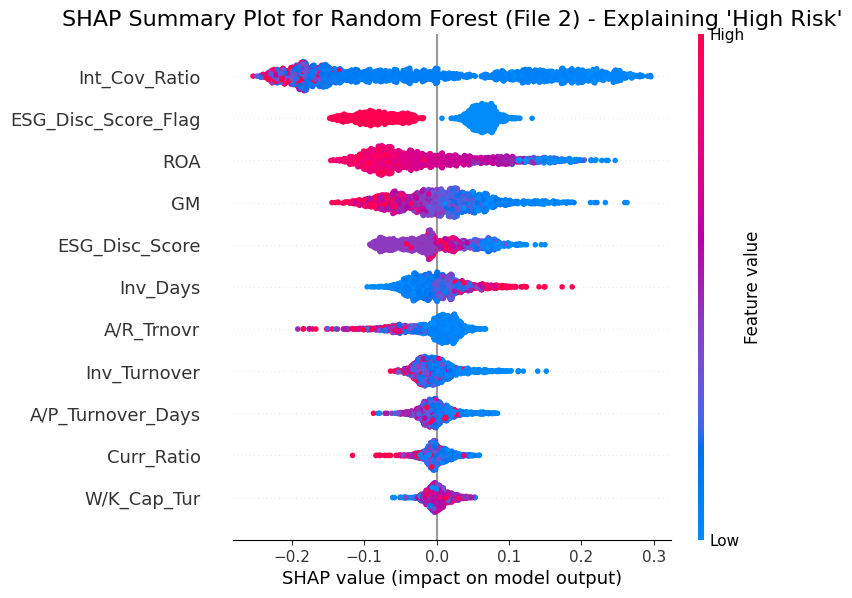

In [ ]:
print("\n--- 4. SHAP Analysis (Explaining Model Predictions) ---")

def run_shap_analysis(final_models, X_train_smote_scaled, X_test_scaled, X_test, file_name):
    """
    This function performs SHAP analysis on the best-performing model
    using the scaled data for calculation and original data for plotting.
    """
    # Select the best-performing model for the explanation
    best_model_name = "Random Forest"
    best_model_shap = final_models[best_model_name]

    # Use the original, unscaled test data DataFrame for the final plot's feature values
    X_test_df = pd.DataFrame(X_test, columns=X_test.columns)

    print(f"Generating SHAP plot for {file_name}...")

    # --- UPDATED: Use scaled data for SHAP calculation ---
    # 1. Create a SHAP explainer. For tree models, providing the training data can improve performance.
    explainer = shap.Explainer(best_model_shap, X_train_smote_scaled)

    # 2. Calculate the SHAP values on the SCALED test set.
    shap_values = explainer(X_test_scaled, check_additivity=False)

    # 3. Generate and display the SHAP summary plot
    print("Displaying SHAP Summary Plot (Beeswarm)...")

    # For binary classification, we explain the 'High Risk' class (class 1)
    # The shap_values object is multi-dimensional; [:,:,1] selects the values for the positive class.
    # We plot the SHAP values against the ORIGINAL (unscaled) X_test for interpretability.
    shap.summary_plot(shap_values[:,:,1], X_test_df, plot_type="dot", show=False)

    plt.title(f"SHAP Summary Plot for {best_model_name} ({file_name}) - Explaining 'High Risk'", fontsize=16)
    plt.show()

# --- Run the SHAP analysis for both files ---
# This code assumes all necessary variables from previous steps exist.
try:
    # Pass the scaled training and test sets to the function
    run_shap_analysis(final_models1, X1_train_smote_scaled, X1_test_scaled, X1_test, "File 1")
    run_shap_analysis(final_models2, X2_train_smote_scaled, X2_test_scaled, X2_test, "File 2")
except NameError:
    print("ERROR: Please make sure you have run all previous steps (0-3)")
    print("to generate the necessary variables before running this step.")

